# Faster R-CNN in Pytorch with Example

In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import numpy as np
from skimage import io
from skimage.transform import resize
import matplotlib.pyplot as plt
import random
import matplotlib.patches as patches
from utils import *
from model import *
import os

import torch
import torchvision
from torchvision import ops
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence

### Load Images

**Note:** The annotations should also contain the corresponding image path

In [2]:
img_width = 1920
img_height = 1080
image_dir = os.path.join("..", "soccernet_data", "tracking", "train", "SNMOT-060")
# annotation_path = "data/annotations.xml"
# image_dir = os.path.join("data", "images")
# name2idx = {'pad': -1, 'camel': 0, 'bird': 1}
# idx2name = {v:k for k, v in name2idx.items()}

#### Create Dataset and Dataloaders

In [3]:
from data_loader import SoccerDatasetSequence, get_dataloader

# od_dataset = ObjectDetectionDataset(annotation_path, image_dir, (img_height, img_width), name2idx)

bs = 3 

# od_dataset = SoccerDatasetSequence((img_height, img_width), image_dir)
# od_dataloader = DataLoader(
#     od_dataset,
#     batch_size=bs,
# )

new_dataloader = get_dataloader(
    sequence_dir=image_dir, 
    img_size=(img_height, img_width), 
    batch_size=bs, 
    shuffle=False # Keep shuffle=False if you want the *first* sequence elements
)


#### Grab a batch for demonstration

In [5]:
# for img_batch, gt_bboxes_batch, gt_classes_batch in od_dataloader:
#     img_data_all = img_batch
#     gt_bboxes_all = gt_bboxes_batch
#     gt_classes_all = gt_classes_batch
#     break
    
# img_data_all = img_data_all[:bs]
# gt_bboxes_all = gt_bboxes_all[:bs]
# gt_classes_all = gt_classes_all[:bs]

# gt_classes_all
img_data_all, gt_bboxes_all, gt_classes_all = next(iter(new_dataloader))
gt_classes_all

tensor([[ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         -1, -1, -1, -1, -1],
        [ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         -1, -1, -1, -1, -1],
        [ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         -1, -1, -1, -1, -1]])

### Display Images and Bounding Boxes

In [6]:
# get class names
gt_class_1 = gt_classes_all[0].long()
gt_class_1 = ["player" for idx in gt_class_1]

gt_class_2 = gt_classes_all[1].long()
gt_class_2 = ["player" for idx in gt_class_2]

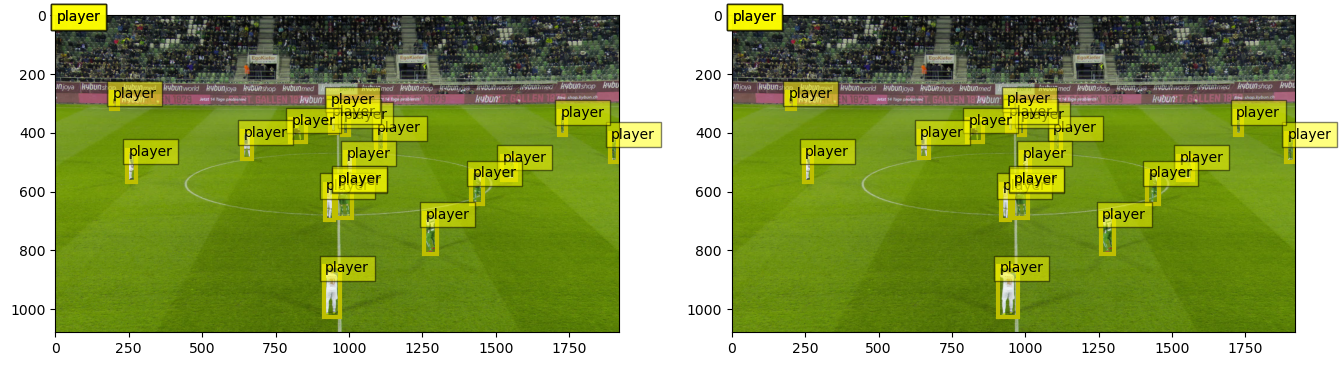

In [7]:
num_images_to_display = 2
nrows, ncols = (1, num_images_to_display)

fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

fig, axes = display_img(img_data_all[:num_images_to_display], fig, axes)

for i in range(num_images_to_display):
    fig, _ = display_bbox(gt_bboxes_all[i], fig, axes[i], classes=gt_class_1)
# fig, _ = display_bbox(gt_bboxes_all[1], fig, axes[1], classes=gt_class_2)

## Convolutional Backbone Network

We will use the first 4 layers of resnet50 as our convolutional backbone

In [9]:
model = torchvision.models.resnet50(pretrained=True)

/opt/anaconda3/envs/ML_FinalProj/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/ML_FinalProj/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
req_layers = list(model.children())[:8]
backbone = nn.Sequential(*req_layers)
# unfreeze all the parameters
for param in backbone.named_parameters():
    param[1].requires_grad = True

# from featureExtractor import InceptionFeatureExtractor
# backbone = InceptionFeatureExtractor()
# backbone.eval()


In [11]:
# run the image through the backbone
out = backbone(img_data_all)

In [12]:
out_c, out_h, out_w = out.size(dim=1), out.size(dim=2), out.size(dim=3)

In [13]:
out_c, out_h, out_w

(2048, 34, 60)

#### Check how much the image has been down-scaled

In [14]:



# width_scale_factor = img_width // out_w
# height_scale_factor = img_height / out_h

width_scale_factor = round(img_width / out_w)
height_scale_factor = round(img_height / out_h)

print(img_width, img_height, out_w, out_h)

height_scale_factor, width_scale_factor

1920 1080 60 34


(32, 32)

### Visualize feature maps

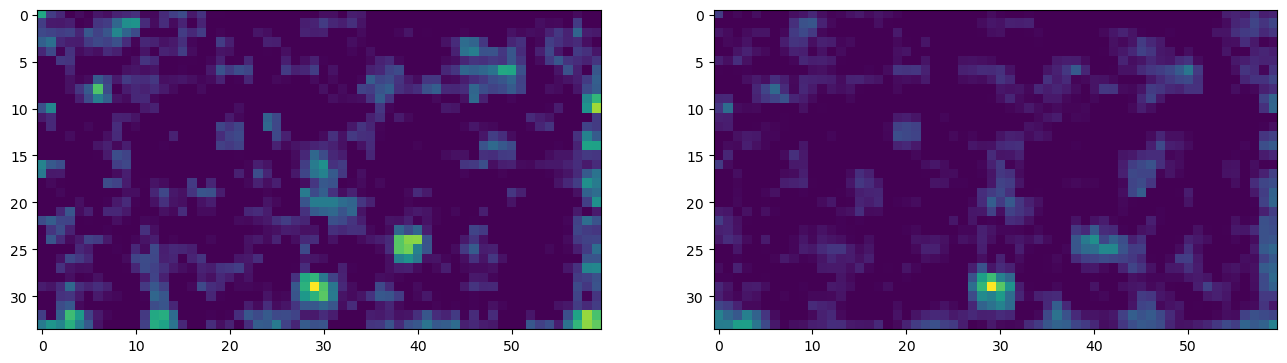

In [15]:
nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

filters_data =[filters[0].detach().numpy() for filters in out[:2]]

fig, axes = display_img(filters_data, fig, axes)

### Generate and Plot Anchor Points

In [16]:
anc_pts_x, anc_pts_y = gen_anc_centers(out_size=(out_h, out_w))

### Display Grid Mapping

In [17]:
# project anchor centers onto the original image
anc_pts_x_proj = anc_pts_x.clone() * width_scale_factor 
anc_pts_y_proj = anc_pts_y.clone() * height_scale_factor

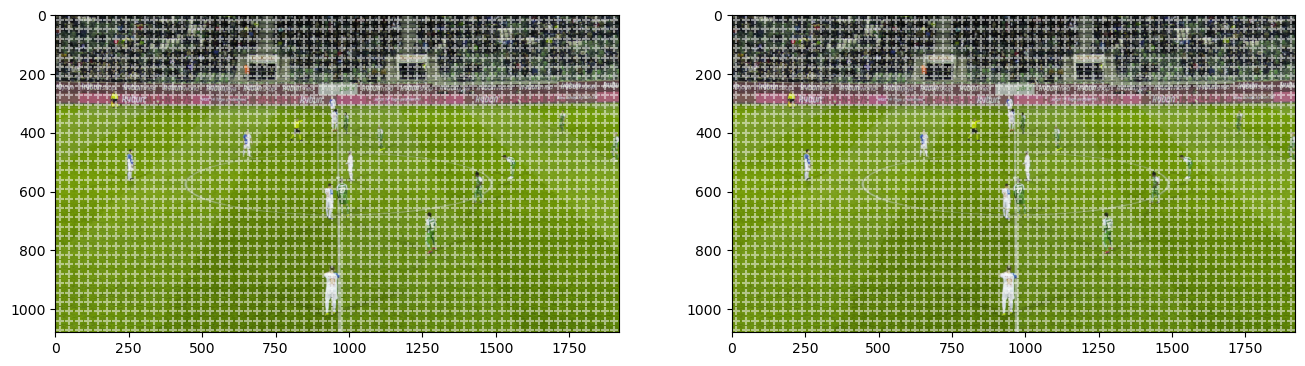

In [18]:
nrows, ncols = (1, num_images_to_display)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

fig, axes = display_img(img_data_all[:num_images_to_display], fig, axes)
for i in range(num_images_to_display):
    fig, _ = display_grid(anc_pts_x_proj, anc_pts_y_proj, fig, axes[i])

### Create Anchor Boxes around Anchor points

In [19]:
anc_scales = [2, 4, 6]
anc_ratios = [0.5, 1, 1.5]
n_anc_boxes = len(anc_scales) * len(anc_ratios) # number of anchor boxes for each anchor point

anc_base = gen_anc_base(anc_pts_x, anc_pts_y, anc_scales, anc_ratios, (out_h, out_w))

In [20]:
# since all the images are scaled to the same size
# we can repeat the anchor base for all the images
anc_boxes_all = anc_base.repeat(img_data_all.size(dim=0), 1, 1, 1, 1)

### plot anchor boxes on a single anchor point

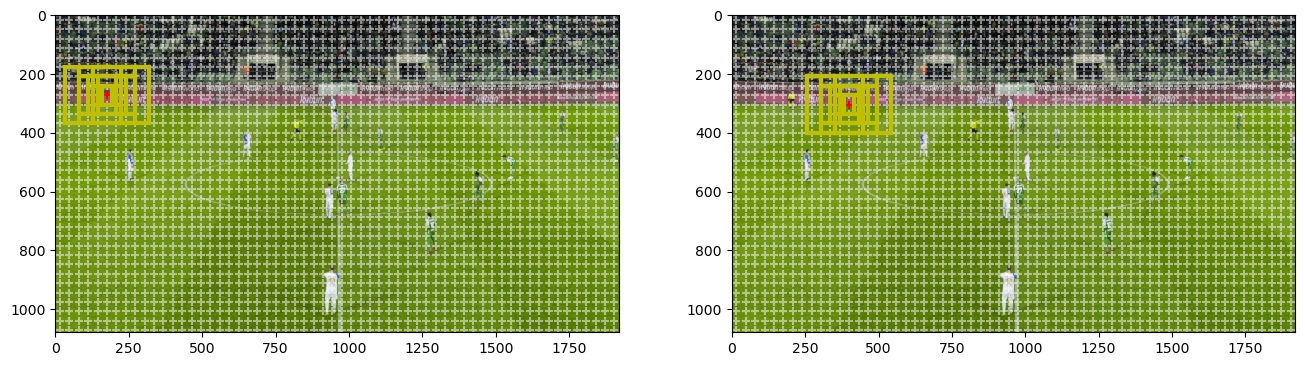

In [21]:
nrows, ncols = (1, num_images_to_display)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

fig, axes = display_img(img_data_all[:num_images_to_display], fig, axes)

# project anchor boxes to the image
anc_boxes_proj = project_bboxes(anc_boxes_all, width_scale_factor, height_scale_factor, mode='a2p')

# plot anchor boxes around selected anchor points
sp = [[5, 8],[12, 9]]
# sp_1 = [5, 8]
# sp_2 = [12, 9]
# bboxes_1 = anc_boxes_proj[0][sp_1[0], sp_1[1]]
# bboxes_2 = anc_boxes_proj[1][sp_2[0], sp_2[1]]

for i in range(num_images_to_display):
    sp_i = sp[i]
    bboxes_i = anc_boxes_proj[i][sp_i[0], sp_i[1]]
    fig, _ = display_grid(anc_pts_x_proj, anc_pts_y_proj, fig, axes[i], (anc_pts_x_proj[sp_i[0]], anc_pts_y_proj[sp_i[1]]))
    fig, _ = display_bbox(bboxes_i, fig, axes[i])


# fig, _ = display_grid(anc_pts_x_proj, anc_pts_y_proj, fig, axes[0], (anc_pts_x_proj[sp_1[0]], anc_pts_y_proj[sp_1[1]]))
# fig, _ = display_grid(anc_pts_x_proj, anc_pts_y_proj, fig, axes[1], (anc_pts_x_proj[sp_2[0]], anc_pts_y_proj[sp_2[1]]))
# fig, _ = display_bbox(bboxes_1, fig, axes[0])
# fig, _ = display_bbox(bboxes_2, fig, axes[1])

### plot all anchor boxes

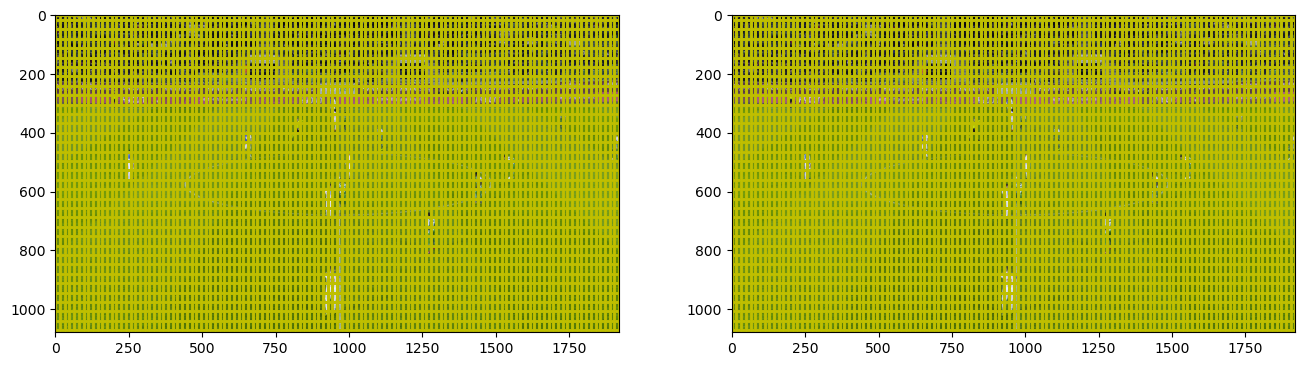

In [22]:

fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))
fig, axes = display_img(img_data_all[:num_images_to_display], fig, axes)

# for i in range(num_images_to_display):
#     fig, _ = display_grid(anc_pts_x_proj, anc_pts_y_proj, fig, axes[i])
#     fig, _ = display_bbox(bboxes, fig, axes[0], line_width=1)

# plot all anchor boxes
for x in range(anc_pts_x_proj.size(dim=0)):
    for y in range(anc_pts_y_proj.size(dim=0)):
        bboxes = anc_boxes_proj[0][x, y]
        fig, _ = display_bbox(bboxes, fig, axes[0], line_width=1)
        fig, _ = display_bbox(bboxes, fig, axes[1], line_width=1)

### Get Positive and Negative Anchors

In [23]:
pos_thresh = 0.7
neg_thresh = 0.3

# project gt bboxes onto the feature map
gt_bboxes_proj = project_bboxes(gt_bboxes_all, width_scale_factor, height_scale_factor, mode='p2a')

In [24]:
positive_anc_ind, negative_anc_ind, GT_conf_scores, \
GT_offsets, GT_class_pos, positive_anc_coords, \
negative_anc_coords, positive_anc_ind_sep = get_req_anchors(anc_boxes_all, gt_bboxes_proj, gt_classes_all, pos_thresh, neg_thresh)

#### Visualize positive anchor coordinates

In [25]:
# project anchor coords to the image space
pos_anc_proj = project_bboxes(positive_anc_coords, width_scale_factor, height_scale_factor, mode='a2p')
neg_anc_proj = project_bboxes(negative_anc_coords, width_scale_factor, height_scale_factor, mode='a2p')

# grab +ve and -ve anchors for each image separately

anc_idx_1 = torch.where(positive_anc_ind_sep == 0)[0]
anc_idx_2 = torch.where(positive_anc_ind_sep == 1)[0]

pos_anc_1 = pos_anc_proj[anc_idx_1]
pos_anc_2 = pos_anc_proj[anc_idx_2]

neg_anc_1 = neg_anc_proj[anc_idx_1]
neg_anc_2 = neg_anc_proj[anc_idx_2]

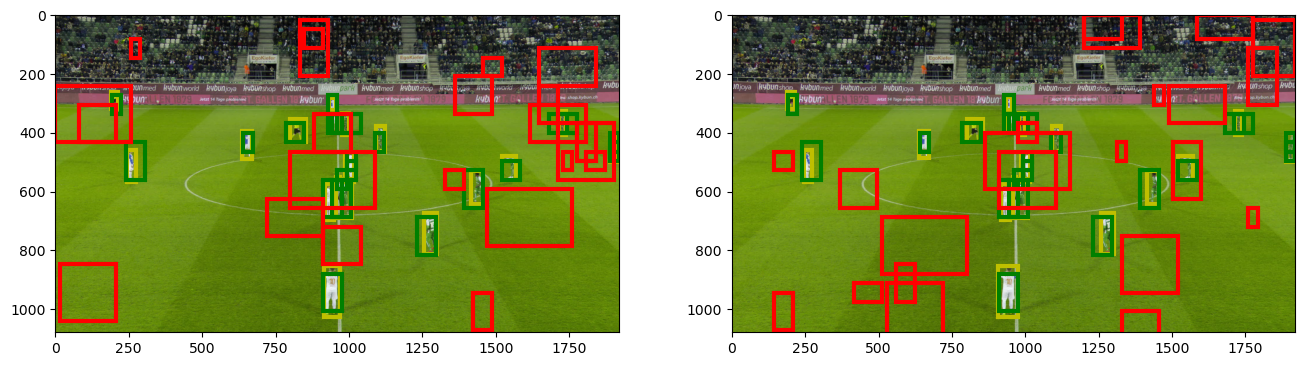

In [26]:
nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

fig, axes = display_img(img_data_all[:num_images_to_display], fig, axes)

# plot groundtruth bboxes
fig, _ = display_bbox(gt_bboxes_all[0], fig, axes[0])
fig, _ = display_bbox(gt_bboxes_all[1], fig, axes[1])

# plot positive anchor boxes
fig, _ = display_bbox(pos_anc_1, fig, axes[0], color='g')
fig, _ = display_bbox(pos_anc_2, fig, axes[1], color='g')

# plot negative anchor boxes
fig, _ = display_bbox(neg_anc_1, fig, axes[0], color='r')
fig, _ = display_bbox(neg_anc_2, fig, axes[1], color='r')

### Building the model

In [27]:
img_size = (img_height, img_width)
out_size = (out_h, out_w)
n_classes = 2# exclude pad idx
roi_size = (2, 2)

detector = TwoStageDetector(img_size, out_size, out_c, n_classes, roi_size)

In [28]:
detector.eval()
total_loss = detector(img_batch, gt_bboxes_batch, gt_classes_batch)
proposals_final, conf_scores_final, classes_final = detector.inference(img_batch)

### Training loop

In [29]:
def training_loop(model, learning_rate, train_dataloader, n_epochs):
    
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    model.train()
    loss_list = []
    
    for i in tqdm(range(n_epochs)):
        total_loss = 0
        for img_batch, gt_bboxes_batch, gt_classes_batch in train_dataloader:
            
            # forward pass
            loss = model(img_batch, gt_bboxes_batch, gt_classes_batch)
            
            # backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        loss_list.append(total_loss)
        
    return loss_list

In [30]:
learning_rate = 1e-3
n_epochs = 1000

loss_list = training_loop(detector, learning_rate, od_dataloader, n_epochs)

  0%|          | 0/1000 [00:00<?, ?it/s]/var/folders/nz/1rwtt6tx04jf15ng2v_zh71h0000gn/T/ipykernel_38524/2978047851.py:20: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Scalar.cpp:23.)
  total_loss += loss.item()
  0%|          | 0/1000 [14:54<?, ?it/s]


KeyboardInterrupt: 

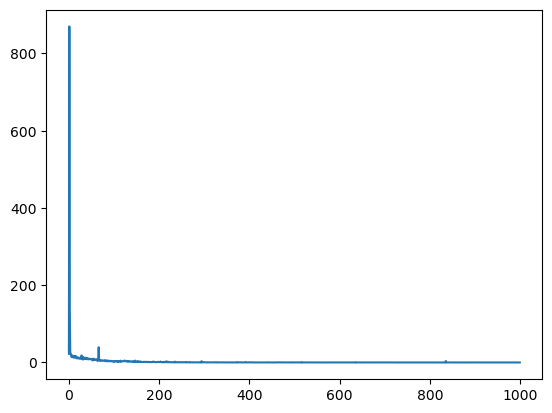

In [ ]:
plt.plot(loss_list)

#### save model

In [42]:
torch.save(detector.state_dict(), "model.pt")

### Inference

In [43]:
detector.eval()
proposals_final, conf_scores_final, classes_final = detector.inference(img_batch, conf_thresh=0.99, nms_thresh=0.05)

In [44]:
# project proposals to the image space
prop_proj_1 = project_bboxes(proposals_final[0], width_scale_factor, height_scale_factor, mode='a2p')
prop_proj_2 = project_bboxes(proposals_final[1], width_scale_factor, height_scale_factor, mode='a2p')

# get classes
classes_pred_1 = [idx2name[cls] for cls in classes_final[0].tolist()]
classes_pred_2 = [idx2name[cls] for cls in classes_final[1].tolist()]

In [47]:
# %matplotlib inline
# %matplotlib notebook

In [50]:
nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

fig, axes = display_img(img_batch, fig, axes)
fig, _ = display_bbox(prop_proj_1, fig, axes[0], classes=classes_pred_1)
fig, _ = display_bbox(prop_proj_2, fig, axes[1], classes=classes_pred_2)

<IPython.core.display.Javascript object>